# TFIDF Implementation

### Load Dependencies

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Initial Setup

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # go to project root

### Load Dataset

In [3]:
df = pd.read_csv(r"..\dataset\processed\clean_dataset.csv")
df.head()

,news_headline,label
0,donald trump sends embarrass new year eve mess...,0
1,drunk brag trump staffer start russian collusi...,0
2,sheriff david clarke become internet joke thre...,0
3,trump obsess even obama name cod website image,0
4,pope francis call donald trump christmas speech,0


In [4]:
df.shape

(34143, 2)

In [5]:
X = df['news_headline']
y = df['label']

pd.set_option('display.max_colwidth', 350)
X.head()

0          donald trump sends embarrass new year eve message disturbing
1        drunk brag trump staffer start russian collusion investigation
2    sheriff david clarke become internet joke threaten poke people eye
3                        trump obsess even obama name cod website image
4                       pope francis call donald trump christmas speech
Name: news_headline, dtype: str

### Split Dataset

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

X_train size: (27314,)
X_test size: (6829,)
y_train size: (27314,)
y_test size: (6829,)


### TFIDF Experiments

In [7]:
# Create empty DataFrame to store results
metrics_df=pd.DataFrame()

In [8]:
from utils.vectorizeTFIDF import *
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [9]:
# Define Model List to Experiment
models = [
    LogisticRegression(), 
    LinearSVC(), 
    MultinomialNB(), 
    RandomForestClassifier(n_estimators= 500, max_depth= 10), 
    XGBClassifier(n_estimators= 500, max_depth= 10)
]
ngram_vals = [(1, 1), (1, 2), (1, 3), (2, 2)]
min_df_vals = [1, 5, 10, 20]
max_df_vals = [0.90, 0.95, 0.99]

# Calculate total configs.
total_configs = len(models)*len(ngram_vals)*len(min_df_vals)*len(max_df_vals)
print("Tatal Configurations:", total_configs)

# Configs per model
config_per_model = int(total_configs/len(models))
print("Configs per Model:", config_per_model)

Tatal Configurations: 240
Configs per Model: 48


In [10]:
import itertools
import time
from tqdm import tqdm

# Create full parameter grid
param_grid = list(itertools.product(models, ngram_vals, min_df_vals, max_df_vals))

total_experiments = len(param_grid)
print(f"Total Experiments: {total_experiments}")

results = []
start_time = time.time()

for idx, (model, n, m, j) in enumerate(tqdm(param_grid), 1):

    row = run_tfidf_experiment(
        model=model,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        ngram_range=n,
        min_df=m,
        max_df=j,
        comments=f"ngram={n}, min_df={m}, max_df={j}"
    )

    results.append(row)

    metrics_df = pd.DataFrame(results)

    end_time = time.time()
print(f"Finished in {(end_time - start_time)/60:.2f} minutes")

Total Experiments: 240


100%|██████████| 240/240 [28:12<00:00,  7.05s/it]

Finished in 28.20 minutes


In [11]:
metrics_df.sort_values(by='f1_test', ascending= False).groupby('model').head(1)

,model,method,ngram_range,min_df,max_df,max_feature,features_limit,train_acc,test_acc,f1_train,f1_test,gap_percent,comments
61,LinearSVC,TFIDF,"(1, 2)",1,0.95,5000,5000,0.9718,0.9296,0.9710,0.9282,4.29,"ngram=(1, 2), min_df=1, max_df=0.95"
26,LogisticRegression,TFIDF,"(1, 3)",1,0.99,5000,5000,0.9485,0.9266,0.9474,0.9255,2.19,"ngram=(1, 3), min_df=1, max_df=0.99"
212,XGBClassifier,TFIDF,"(1, 2)",10,0.99,4538,5000,0.9882,0.9262,0.9879,0.9251,6.28,"ngram=(1, 2), min_df=10, max_df=0.99"
111,MultinomialNB,TFIDF,"(1, 2)",5,0.90,5000,5000,0.9340,0.9170,0.9316,0.9139,1.78,"ngram=(1, 2), min_df=5, max_df=0.9"
147,RandomForestClassifier,TFIDF,"(1, 1)",5,0.90,4888,5000,0.8744,0.8637,0.8694,0.8584,1.10,"ngram=(1, 1), min_df=5, max_df=0.9"


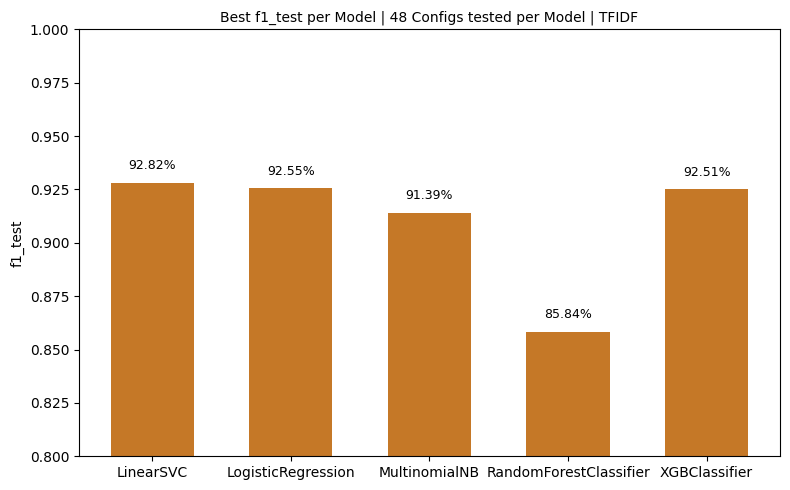

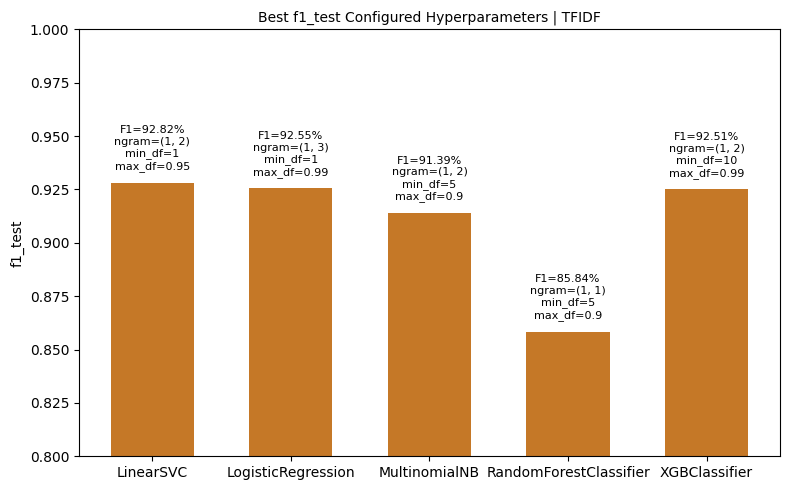

In [12]:
from utils.visualize import plot_best_model_results
plot_best_model_results(metrics_df, 'f1_test', vectorizer_name="TFIDF", total_configs=config_per_model, color='#C57827')

In [21]:
metrics_df.to_csv("../results/TFIDF_lr_svm_nb_rf_xgb_results.csv")

### Additional Analysis

* Take the best configuration and confirm the results.


TF-IDF Vectorizer
Vectorization completed
Total Features: 5000
Logistic Regression
======Classfication Report======
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3513
           1       0.91      0.94      0.93      3316

    accuracy                           0.93      6829
   macro avg       0.93      0.93      0.93      6829
weighted avg       0.93      0.93      0.93      6829

========Confusion Matrix========


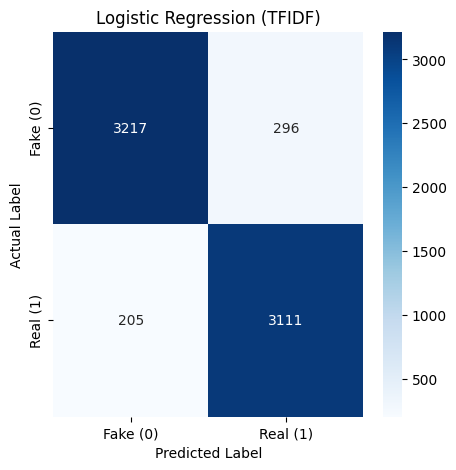

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
from src.vectorize import get_vectorize
lr = LogisticRegression()

_, _, lr_X_train_vec, lr_X_test_vec = get_vectorize(
    X_train,
    X_test,
    method='tfidf',
    ngram_range=(1,3),
    min_df=1,
    max_df=0.99,
    max_features=5000
)

# Fit model
lr_model = lr.fit(lr_X_train_vec, y_train)

# Predictions
y_pred_test = lr_model.predict(lr_X_test_vec)
y_pred_train = lr_model.predict(lr_X_train_vec)

# Classification report (test)
report = classification_report(y_test, y_pred_test)
matrix = confusion_matrix(y_test, y_pred_test)

print("Logistic Regression")
print("======Classfication Report======")
print(report)

print("========Confusion Matrix========")
# Confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(
    matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Fake (0)', 'Real (1)'],
    yticklabels=['Fake (0)', 'Real (1)']
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Logistic Regression (TFIDF)")
plt.show()

TF-IDF Vectorizer
Vectorization completed
Total Features: 5000
LinearSVC Regression
======Classfication Report======
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3513
           1       0.92      0.94      0.93      3316

    accuracy                           0.93      6829
   macro avg       0.93      0.93      0.93      6829
weighted avg       0.93      0.93      0.93      6829

========Confusion Matrix========


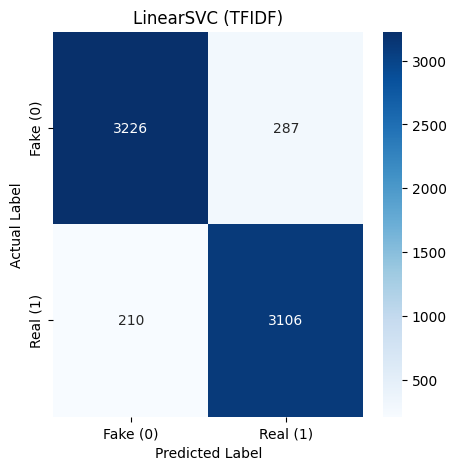

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
from src.vectorize import get_vectorize
lsvc = LinearSVC()

_, _, lsvc_X_train_vec, lsvc_X_test_vec = get_vectorize(
    X_train,
    X_test,
    method='tfidf',
    ngram_range=(1,3),
    min_df=1,
    max_df=0.99,
    max_features=5000
)

# Fit model
lsvc_model = lsvc.fit(lsvc_X_train_vec, y_train)

# Predictions
y_pred_test = lsvc_model.predict(lsvc_X_test_vec)
y_pred_train = lsvc_model.predict(lsvc_X_train_vec)

# Classification report (test)
report = classification_report(y_test, y_pred_test)
matrix = confusion_matrix(y_test, y_pred_test)

print("LinearSVC Regression")
print("======Classfication Report======")
print(report)

print("========Confusion Matrix========")
# Confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(
    matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Fake (0)', 'Real (1)'],
    yticklabels=['Fake (0)', 'Real (1)']
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("LinearSVC (TFIDF)")
plt.show()